In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import datawig

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
train_df = pd.read_csv('C:/Users/gisic/gisic/cancer/open/train.csv')
test_df = pd.read_csv('C:/Users/gisic/gisic/cancer/open/test.csv')

In [7]:
data_filled_tr = train_df[['나이','진단명','암의 위치','암의 개수','NG','HG',
                       'HG_score_1','HG_score_2','HG_score_3','T_category','HER2_SISH_ratio','암의 장경','N_category']]

data_filled_te = test_df[['나이','진단명','암의 위치','암의 개수','NG','HG',
                       'HG_score_1','HG_score_2','HG_score_3','T_category','HER2_SISH_ratio','암의 장경']]

In [8]:
train_df.columns

Index(['ID', 'img_path', 'mask_path', '나이', '수술연월일', '진단명', '암의 위치', '암의 개수',
       '암의 장경', 'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'BRCA_mutation',
       'N_category'],
      dtype='object')

In [9]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             4
ER                     1
ER_Allred_score      297
PR                     1
PR_Allred_score      453
KI-67_LI_percent     235
HER2                  14
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
BRCA_mutation        945
N_category             0
dtype: int64

In [10]:
train_df[train_df.isnull().sum(1)==11]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
314,BC_01_1533,./train_imgs/BC_01_1533.png,-,64,2016-10-06,1,2,1,NaN,1.0,...,NaN,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0
797,BC_01_2913,./train_imgs/BC_01_2913.png,-,66,2008-04-22,1,1,1,18.0,NaN,...,NaN,0.0,NaN,15.0,1.0,2.0,NaN,NaN,NaN,0
820,BC_01_2941,./train_imgs/BC_01_2941.png,-,44,2008-05-06,2,1,1,10.0,NaN,...,NaN,1.0,NaN,20.0,0.0,1.0,NaN,NaN,NaN,1
858,BC_01_2993,./train_imgs/BC_01_2993.png,-,45,2007-08-22,4,2,1,110.0,NaN,...,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
883,BC_01_3028,./train_imgs/BC_01_3028.png,-,44,2007-05-16,1,2,1,14.0,2.0,...,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
894,BC_01_3040,./train_imgs/BC_01_3040.png,-,61,2007-04-09,1,1,1,12.0,2.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
897,BC_01_3043,./train_imgs/BC_01_3043.png,-,74,2007-04-03,1,2,1,0.9,NaN,...,NaN,0.0,NaN,NaN,1.0,3.0,NaN,NaN,NaN,0
898,BC_01_3044,./train_imgs/BC_01_3044.png,-,54,2007-03-30,1,1,1,18.0,3.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
899,BC_01_3045,./train_imgs/BC_01_3045.png,-,46,2007-03-30,1,1,1,15.0,2.0,...,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0


>>- 정수화

int_list = ['T_category','진단명','암의 위치','암의 개수','NG','HG','HG_score_1','HG_score_2','HG_score_3','DCIS_or_LCIS_여부'
           ,'DCIS_or_LCIS_type','ER','ER_Allred_score','PR','PR_Allred_score','HER2','HER2_IHC','HER2_SISH','N_category']
for i in int_list:
    if train_df[i].isnull()==False:
        train_df[i] = train_df[i].astype(int)

>>- BRCA 검사는 값이 의미가 없다고 판단하여 변수제거

In [11]:
train_df["BRCA_mutation"].value_counts()

0.0    51
2.0     4
Name: BRCA_mutation, dtype: int64

In [12]:
train_df = train_df.drop(['BRCA_mutation'],axis = 1)

>>- ER과 PR이 결측값 1개씩 있는데 이것 부터 처리

In [13]:
print(train_df[train_df['ER'].isnull()].iloc[:,[3,5,6,7,8,9,10,11,12,13,14,15,16,17]])
print(train_df[train_df['ER'].isnull()].iloc[:,[18,19,20,21,22,23,24,25,26]])

     나이  진단명  암의 위치  암의 개수  암의 장경   NG  HG  HG_score_1  HG_score_2  \
266  52    1      1      1    NaN  1.0 NaN         NaN         NaN   

     HG_score_3  DCIS_or_LCIS_여부  DCIS_or_LCIS_type  T_category  ER  
266         NaN                1                1.0         0.0 NaN  
     ER_Allred_score  PR  PR_Allred_score  KI-67_LI_percent  HER2  HER2_IHC  \
266              NaN NaN              NaN               NaN   NaN       NaN   

     HER2_SISH  HER2_SISH_ratio  N_category  
266        NaN              NaN           0  


In [14]:
Fill_null = ['ER','PR']
for i in Fill_null:
    train_df.loc[(train_df["암의 개수"]<=1) & (train_df["DCIS_or_LCIS_type"] !=2 ) & 
                 ((train_df["T_category"] == 0)|(train_df["T_category"].isnull())) &
                 (((train_df['암의 장경']<19)|(train_df['암의 장경'].isnull()))) & 
                 (train_df[i].isnull()),i] = 1

In [15]:
train_df.loc[(train_df["암의 개수"]<=1) & (train_df["DCIS_or_LCIS_type"] !=2 ) & 
                 ((train_df["T_category"] == 0)|(train_df["T_category"].isnull())) &
                 (((train_df['암의 장경']<19)|(train_df['암의 장경'].isnull()))), 'HER2'] = 0

In [16]:
train_df.loc[(train_df["암의 개수"]<=1) & (train_df["DCIS_or_LCIS_type"] !=2 ) & 
                 ((train_df["T_category"] == 0)|(train_df["T_category"].isnull())) &
                 (((train_df['암의 장경']<19)|(train_df['암의 장경'].isnull())))]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category
17,BC_01_0213,./train_imgs/BC_01_0213.png,-,53,2020-06-19,1,2,1,NaN,NaN,...,1.0,8.0,1.0,8.0,17.61,0.0,1.0,NaN,NaN,0
58,BC_01_0295,./train_imgs/BC_01_0295.png,-,65,2020-04-02,1,2,1,NaN,1.0,...,1.0,8.0,1.0,8.0,4.97,0.0,0.0,NaN,NaN,0
71,BC_01_0342,./train_imgs/BC_01_0342.png,-,36,2020-03-05,1,1,1,NaN,1.0,...,1.0,7.0,1.0,8.0,8.21,0.0,2.0,NaN,NaN,0
72,BC_01_0348,./train_imgs/BC_01_0348.png,-,43,2020-01-06,1,1,1,NaN,1.0,...,1.0,7.0,1.0,8.0,3.03,0.0,1.0,NaN,NaN,0
94,BC_01_0491,./train_imgs/BC_01_0491.png,-,47,2019-09-06,1,1,1,NaN,1.0,...,1.0,7.0,1.0,5.0,0.42,0.0,2.0,NaN,NaN,0
109,BC_01_0547,./train_imgs/BC_01_0547.png,-,57,2019-04-22,1,2,1,0.0,2.0,...,0.0,NaN,0.0,NaN,28.27,0.0,3.0,NaN,NaN,1
112,BC_01_0553,./train_imgs/BC_01_0553.png,-,40,2019-07-09,1,1,1,NaN,2.0,...,1.0,8.0,1.0,7.0,34.25,0.0,2.0,0.0,1.11,1
114,BC_01_0556,./train_imgs/BC_01_0556.png,-,69,2018-12-12,1,1,1,NaN,1.0,...,1.0,8.0,1.0,6.0,5.50,0.0,0.0,NaN,NaN,0
115,BC_01_0561,./train_imgs/BC_01_0561.png,-,54,2019-03-14,1,2,1,0.0,NaN,...,0.0,NaN,0.0,NaN,42.81,0.0,1.0,NaN,NaN,1
117,BC_01_0567,./train_imgs/BC_01_0567.png,-,42,2019-02-01,1,2,1,0.0,3.0,...,1.0,7.0,1.0,7.0,47.79,0.0,0.0,NaN,NaN,1


In [17]:
train_df.loc[(train_df["암의 장경"]<=19) &(train_df["암의 장경"]>=10) & (train_df["T_category"].isnull()), "T_category"] = 2
train_df.loc[(train_df["암의 장경"]<=30) &(train_df["암의 장경"]>=19) & (train_df["T_category"].isnull()), "T_category"] = 3
train_df.loc[(train_df["암의 장경"]>=30) & (train_df["T_category"].isnull()), "T_category"] = 4

In [18]:
train_df.loc[(train_df["암의 장경"] == 0) & (train_df["T_category"].isnull()), "암의 장경"] = 40

In [19]:
train_df.loc[(train_df["암의 장경"]>=50), "암의 장경"] = 50

>>- 병원에서 림프절 전이가 진행되어 T범위를 측정하지 않고 차후를 검사할 경우

>>- 가정을 세우자면 이런 사람들은 T카테고리를 측정하지 않고 암의 장경이 0 이거나 KI-67을 측정하였다.
>>>- 이말은 측정하지 않은 값은 더 이상 치료 과정에 필요가 없고 측정한 값은 림프절 전이 구간에 치료에 측정한 결과라 T와 N과정에 겹친 것일 것이다.
>>>>- 이러한 결과로 유추해볼 때 암의 장경이 0.0일 경우에도 무언가 있을 수 있다.

>- 유추 결과로는 아마 전이된 사람들이라 치료가 필요한 사람들에서
치료가 끝나 암의 크기가 0인 사람으로 나눌 수 있을 것이라 생각된다.
>>- 따라서 결측값인 T는 4의 값으로 채운다

In [20]:
train_df['T_category'] = train_df['T_category'].fillna(4)

In [21]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             0
ER                     0
ER_Allred_score      297
PR                     0
PR_Allred_score      453
KI-67_LI_percent     235
HER2                   4
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
N_category             0
dtype: int64

In [22]:
train_df[train_df["HER2"].isnull()]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category
18,BC_01_0214,./train_imgs/BC_01_0214.png,-,58,2020-06-29,1,1,1,NaN,NaN,...,0.0,NaN,0.0,NaN,28.66,NaN,2.0,0.0,30.0,0
125,BC_01_0607,./train_imgs/BC_01_0607.png,-,66,2018-08-10,1,2,1,0.7,2.0,...,0.0,NaN,0.0,NaN,8.66,NaN,2.0,NaN,NaN,1
321,BC_01_1570,./train_imgs/BC_01_1570.png,-,49,2016-09-29,1,1,2,NaN,1.0,...,1.0,6.0,1.0,8.0,3.53,NaN,2.0,NaN,NaN,0
399,BC_01_1951,./train_imgs/BC_01_1951.png,-,53,2015-09-15,1,1,1,NaN,1.0,...,1.0,7.0,1.0,5.0,1.00,NaN,2.0,NaN,NaN,0


In [23]:
print(train_df[train_df['HER2'].isnull()].iloc[:,[3,5,6,7,8,9,10,11,12,13,14,15,16,17]])
print(train_df[train_df['HER2'].isnull()].iloc[:,[18,19,20,21,22,23,24,25,26]])

     나이  진단명  암의 위치  암의 개수  암의 장경   NG   HG  HG_score_1  HG_score_2  \
18   58    1      1      1    NaN  NaN  NaN         NaN         NaN   
125  66    1      2      1    0.7  2.0  2.0         3.0         2.0   
321  49    1      1      2    NaN  1.0  NaN         NaN         NaN   
399  53    1      1      1    NaN  1.0  NaN         NaN         NaN   

     HG_score_3  DCIS_or_LCIS_여부  DCIS_or_LCIS_type  T_category   ER  
18          NaN                1                2.0         0.0  0.0  
125         1.0                0                2.0         1.0  0.0  
321         NaN                1                NaN         0.0  1.0  
399         NaN                1                2.0         0.0  1.0  
     ER_Allred_score   PR  PR_Allred_score  KI-67_LI_percent  HER2  HER2_IHC  \
18               NaN  0.0              NaN             28.66   NaN       2.0   
125              NaN  0.0              NaN              8.66   NaN       2.0   
321              6.0  1.0              8.0       

In [24]:
train_df[train_df['HER2']==0]['N_category'].value_counts()

1    408
0    345
Name: N_category, dtype: int64

In [25]:
train_df[train_df['HER2']==1]['N_category'].value_counts()

0    138
1    105
Name: N_category, dtype: int64

In [26]:
tmep_T = train_df.loc[(train_df["HER2"]==1)]

In [27]:
tmep_T.columns

Index(['ID', 'img_path', 'mask_path', '나이', '수술연월일', '진단명', '암의 위치', '암의 개수',
       '암의 장경', 'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'N_category'],
      dtype='object')

In [28]:
values_1 = ['나이','진단명', '암의 위치', '암의 개수',
       'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio']

In [29]:
train_df.loc[(train_df["진단명"]==1) &(train_df["암의 개수"]==1) &(train_df["ER"]==1) & (train_df["PR"]==1),"HER2"].value_counts()

0.0    373
1.0     90
Name: HER2, dtype: int64

In [30]:
from datawig import SimpleImputer, Imputer
from datawig.utils import random_split
from datawig.column_encoders import *
from datawig.mxnet_input_symbols import *

In [31]:
train_wig = train_df[['DCIS_or_LCIS_여부','T_category','ER','PR','나이','진단명','암의 위치','암의 개수','HER2']]

In [32]:
train_wig_nonull = train_df[train_df['HER2'].notnull()]

In [33]:
train_wig_null= train_df[train_df['HER2'].isnull()]

In [34]:
# Define columns with useful info for to-be-imputed column
input_cols = values_1

# Define column to be imputed
output_col_num = 'HER2' 

In [35]:
# Initialize SimpleImputer model for numerical imputation
imputer_num = SimpleImputer(
            input_columns=input_cols,
            output_column=output_col_num,  # Column to be imputed
            )

In [36]:
train_wig_nonull= train_df[['나이','진단명', '암의 위치', '암의 개수',
       'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio','HER2']]

In [37]:
train_wig_nonull

,나이,진단명,암의 위치,암의 개수,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,...,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2_IHC,HER2_SISH,HER2_SISH_ratio,HER2
0,63,1,2,1,2.0,1.0,2.0,2.0,1.0,2,...,1.0,1.0,8.0,1.0,6.0,12.0,1.0,NaN,NaN,0.0
1,51,1,1,1,3.0,3.0,3.0,3.0,3.0,0,...,2.0,0.0,NaN,0.0,NaN,70.0,0.0,NaN,NaN,0.0
2,37,1,2,1,2.0,NaN,NaN,NaN,NaN,1,...,0.0,1.0,7.0,1.0,4.0,7.0,1.0,NaN,NaN,0.0
3,54,1,2,1,3.0,3.0,3.0,3.0,2.0,1,...,0.0,0.0,NaN,0.0,NaN,1.0,3.0,NaN,NaN,1.0
4,57,1,2,1,2.0,2.0,3.0,2.0,1.0,2,...,1.0,1.0,8.0,0.0,NaN,8.0,2.0,1.0,5.44,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,1,2,1,1.0,1.0,2.0,1.0,1.0,0,...,2.0,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
996,48,1,1,1,1.0,1.0,1.0,1.0,1.0,0,...,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0
997,64,1,2,1,1.0,1.0,2.0,1.0,2.0,0,...,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0
998,50,1,1,1,1.0,1.0,1.0,2.0,1.0,0,...,1.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [68]:
imputer_num.fit(train_df=train_wig_nonull,
                    num_epochs=200,
                   )

INFO:root:Epoch[0] Batch [0-29]	Speed: 18159.36 samples/sec	cross-entropy=1.100762	HER2-accuracy=0.000000
INFO:root:Epoch[0] Train-cross-entropy=0.917463
INFO:root:Epoch[0] Train-HER2-accuracy=0.000000
INFO:root:Epoch[0] Time cost=0.094
INFO:root:Saved checkpoint to "her2\model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=2.544660
INFO:root:Epoch[0] Validation-HER2-accuracy=0.000000
INFO:root:Epoch[1] Batch [0-29]	Speed: 16464.81 samples/sec	cross-entropy=1.154034	HER2-accuracy=0.000000
INFO:root:Epoch[1] Train-cross-entropy=0.961261
INFO:root:Epoch[1] Train-HER2-accuracy=0.000000
INFO:root:Epoch[1] Time cost=0.056
INFO:root:Saved checkpoint to "her2\model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=2.779962
INFO:root:Epoch[1] Validation-HER2-accuracy=0.000000
INFO:root:Epoch[2] Batch [0-29]	Speed: 18499.59 samples/sec	cross-entropy=1.145643	HER2-accuracy=0.000000
INFO:root:Epoch[2] Train-cross-entropy=0.956487
INFO:root:Epoch[2] Train-HER2-accuracy=0.000000
IN

In [69]:
predictions_num = imputer_num.predict(train_wig_null)
HER2_imputed = predictions_num[predictions_num['HER2'].isnull()]

In [71]:
HER2_imputed.loc[(HER2_imputed['HER2_imputed']>0.5) ,'HER2'] =1

In [72]:
HER2_imputed.loc[(HER2_imputed['HER2_imputed']<=0.5) ,'HER2'] =0

In [73]:
HER2_imputed

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category,HER2_imputed
18,BC_01_0214,./train_imgs/BC_01_0214.png,-,58,2020-06-29,1,1,1,NaN,NaN,...,NaN,0.0,NaN,28.66,1.0,2.0,0.0,30.0,0,0.581255
125,BC_01_0607,./train_imgs/BC_01_0607.png,-,66,2018-08-10,1,2,1,0.7,2.0,...,NaN,0.0,NaN,8.66,1.0,2.0,NaN,NaN,1,0.820845
321,BC_01_1570,./train_imgs/BC_01_1570.png,-,49,2016-09-29,1,1,2,NaN,1.0,...,6.0,1.0,8.0,3.53,0.0,2.0,NaN,NaN,0,0.271916
399,BC_01_1951,./train_imgs/BC_01_1951.png,-,53,2015-09-15,1,1,1,NaN,1.0,...,7.0,1.0,5.0,1.00,0.0,2.0,NaN,NaN,0,0.235015


In [82]:
train_df.loc[((HER2_imputed["HER2"]==1) &(train_df["HER2"].isnull() == True)),"HER2"] =1
train_df.loc[((HER2_imputed["HER2"]==0) &(train_df["HER2"].isnull() == True)),"HER2"] =0

In [85]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             0
ER                     0
ER_Allred_score      297
PR                     0
PR_Allred_score      453
KI-67_LI_percent     235
HER2                   0
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
N_category             0
dtype: int64

In [88]:
train_df['HER2_IHC'].value_counts()

2.0    324
1.0    314
0.0    251
3.0     87
Name: HER2_IHC, dtype: int64

In [90]:
train_df[train_df['HER2_IHC'].isnull()]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category
266,BC_01_1223,./train_imgs/BC_01_1223.png,-,52,2019-03-20,1,1,1,NaN,1.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0
869,BC_01_3010,./train_imgs/BC_01_3010.png,-,57,2007-07-03,1,2,1,15.0,3.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0
872,BC_01_3013,./train_imgs/BC_01_3013.png,-,51,2007-06-29,1,2,1,14.0,3.0,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0
874,BC_01_3015,./train_imgs/BC_01_3015.png,-,41,2007-06-13,1,2,1,15.0,3.0,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0
877,BC_01_3018,./train_imgs/BC_01_3018.png,-,47,2007-09-10,1,1,1,13.0,2.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,1
880,BC_01_3021,./train_imgs/BC_01_3021.png,-,61,2007-06-08,1,1,1,28.0,2.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,1
881,BC_01_3025,./train_imgs/BC_01_3025.png,-,46,2007-06-15,1,1,1,15.0,3.0,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0
883,BC_01_3028,./train_imgs/BC_01_3028.png,-,44,2007-05-16,1,2,1,14.0,2.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0
885,BC_01_3031,./train_imgs/BC_01_3031.png,-,67,2007-04-27,1,1,1,35.0,2.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,1
886,BC_01_3032,./train_imgs/BC_01_3032.png,-,48,2007-05-15,1,2,1,25.0,3.0,...,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0


In [116]:
train_df[train_df['HER2_IHC'].notnull()]['HER2_IHC'].value_counts()

2.0    324
1.0    314
0.0    251
3.0     87
Name: HER2_IHC, dtype: int64

In [120]:
train_df.loc[(train_df[['HER2_IHC'].notnull()==True]) & (train_df['HER2']==1), 'HER2']

AttributeError: 'list' object has no attribute 'notnull'

In [128]:
(train_df['HER2_IHC'])[(train_df['HER2']==1)].value_counts()

2.0    155
3.0     86
1.0      4
Name: HER2_IHC, dtype: int64

In [129]:
(train_df['HER2_IHC'])[(train_df['HER2']==0)].value_counts()

1.0    310
0.0    251
2.0    169
3.0      1
Name: HER2_IHC, dtype: int64

In [91]:
df_HER2_IHC = train_df.drop(['ID','N_category','HER2_SISH_ratio','HER2_SISH','KI-67_LI_percent','PR_Allred_score'
                            ,'ER_Allred_score','수술연월일','img_path','mask_path'],axis =1)

In [94]:
df_HER2_IHC.columns

Index(['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'PR', 'HER2', 'HER2_IHC'],
      dtype='object')

In [103]:
df_HER2_IHC

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,PR,HER2,HER2_IHC
0,63,1,2,1,19.0,2.0,1.0,2.0,2.0,1.0,2,NaN,1.0,1.0,1.0,0.0,1.0
1,51,1,1,1,22.0,3.0,3.0,3.0,3.0,3.0,0,NaN,2.0,0.0,0.0,0.0,0.0
2,37,1,2,1,NaN,2.0,NaN,NaN,NaN,NaN,1,2.0,0.0,1.0,1.0,0.0,1.0
3,54,1,2,1,0.0,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,0.0,1.0,3.0
4,57,1,2,1,8.0,2.0,2.0,3.0,2.0,1.0,2,NaN,1.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,1,2,1,25.0,1.0,1.0,2.0,1.0,1.0,0,NaN,2.0,1.0,0.0,0.0,0.0
996,48,1,1,1,7.0,1.0,1.0,1.0,1.0,1.0,0,NaN,1.0,1.0,1.0,0.0,0.0
997,64,1,2,1,15.0,1.0,1.0,2.0,1.0,2.0,0,NaN,1.0,1.0,1.0,0.0,0.0
998,50,1,1,1,7.0,1.0,1.0,1.0,2.0,1.0,0,NaN,1.0,0.0,0.0,0.0,0.0


In [99]:
HER2_IHC_cols = ['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'PR', 'HER2', 'HER2_IHC']

In [104]:
def fill_null_datawig(train_df, output_col_cum, input_cols):
    train_wig_nonull = train_df[train_df[output_col_cum].notnull()]
    train_wig_null= train_df[train_df[output_col_cum].isnull()]
    imputer_num = SimpleImputer(
            input_columns=input_cols,
            output_column=output_col_num,  # Column to be imputed
            )
    imputer_num.fit(train_df=train_wig_nonull,
                    num_epochs=200,
                   )
    
    predictions_num = imputer_num.predict(train_wig_null)
    return predictions_num

In [109]:
def fill_null_datawig(train_df, output_col_cum, input_cols):
    train_wig_nonull = train_df[train_df[output_col_cum].notnull()]
    train_wig_null= train_df[train_df[output_col_cum].isnull()]
    imputer_num = SimpleImputer(
            input_columns=input_cols,
            output_column=output_col_num,  # Column to be imputed
            )
    imputer_num.fit(train_df=train_wig_nonull,
                    num_epochs=200,
                   )
    
    predictions_num = imputer_num.predict(train_wig_nonull)
    return predictions_num

In [110]:
df_HER2_IHC_predict = fill_null_datawig(df_HER2_IHC, 'HER2_IHC', HER2_IHC_cols)

In [111]:
df_HER2_IHC_predict

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,PR,HER2,HER2_IHC,HER2_imputed
0,63,1,2,1,19.0,2.0,1.0,2.0,2.0,1.0,2,NaN,1.0,1.0,1.0,0.0,1.0,-0.016496
1,51,1,1,1,22.0,3.0,3.0,3.0,3.0,3.0,0,NaN,2.0,0.0,0.0,0.0,0.0,-0.000875
2,37,1,2,1,NaN,2.0,NaN,NaN,NaN,NaN,1,2.0,0.0,1.0,1.0,0.0,1.0,-0.041636
3,54,1,2,1,0.0,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,0.0,1.0,3.0,1.054530
4,57,1,2,1,8.0,2.0,2.0,3.0,2.0,1.0,2,NaN,1.0,1.0,0.0,1.0,2.0,1.006020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,1,2,1,25.0,1.0,1.0,2.0,1.0,1.0,0,NaN,2.0,1.0,0.0,0.0,0.0,-0.041206
996,48,1,1,1,7.0,1.0,1.0,1.0,1.0,1.0,0,NaN,1.0,1.0,1.0,0.0,0.0,-0.038173
997,64,1,2,1,15.0,1.0,1.0,2.0,1.0,2.0,0,NaN,1.0,1.0,1.0,0.0,0.0,-0.004004
998,50,1,1,1,7.0,1.0,1.0,1.0,2.0,1.0,0,NaN,1.0,0.0,0.0,0.0,0.0,-0.032312


##### 설정을 체크가 되어있으면 치료가 필요하다는 것이고 1은 전이일 확률이 높다

##### 변수로 만들 때 체크가 안되어있으면 0 체크가 되어있으면 1 체크가 되어있고 치료면 2

In [ ]:
A_L['암의 장경'].sum()*(3/4)

##### @@@@@HER2_SISH 결측 0으로 채움

In [ ]:
train_df = train_df.replace({'HER2_SISH' : 1}, 2)
train_df = train_df.replace({'HER2_SISH' : 0}, 1)
train_df['HER2_SISH'] = train_df['HER2_SISH'].fillna(0)

In [ ]:
train_df['HER2_SISH'].value_counts()

##### 암의 위치는 림프절 전이랑 그닥 관련 없는 듯?
하지만 다른 변수랑 관련있지 않을까? -> 그래서 다른 변수의 결측값을 메울 수 있지 않을까?

In [ ]:
train_df[train_df['암의 위치'] == 3]['N_category'].value_counts()

In [25]:
train_df[train_df['진단명'] == 2]['N_category'].value_counts()

1    41
0    24
Name: N_category, dtype: int64

##### 암의 개수는 무언 가 있을 거같아서 암의 위치하고 암의 개수하고 연관성을 살펴보자

암의 위치가 1번(오른쪽)일 때 암의 개수는 하나일때가 408개 여러개 일때가 64개

In [26]:
# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_loc = train_df['암의 위치'] == 3

# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_num = train_df['암의 개수'] == 1

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
subset_df = train_df[cancer_loc & cancer_num]

# 결과를 출력합니다.
subset_df['N_category'].value_counts()

0    15
1    12
Name: N_category, dtype: int64

In [27]:
# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_loc = train_df['암의 위치'] == 3

# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_num = train_df['암의 개수'] == 2

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
subset_df2 = train_df[cancer_loc & cancer_num]

# 결과를 출력합니다.
#subset_df2

In [28]:
# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_loc = train_df['암의 위치'] == 1

# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_num = train_df['암의 개수'] == 2

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
subset_df3 = train_df[cancer_loc & cancer_num]

# 결과를 출력합니다.
#subset_df3

In [29]:
subset_df3['N_category'].value_counts()

1    52
0    12
Name: N_category, dtype: int64

In [30]:
# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_loc = train_df['암의 위치'] == 2

# 컬럼의 값과 조건을 비교합니다.
# 그 결과를 새로운 변수에 할당합니다.
cancer_num = train_df['암의 개수'] == 2

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
subset_df3 = train_df[cancer_loc & cancer_num]

# 결과를 출력합니다.
#subset_df3

In [31]:
subset_df3['N_category'].value_counts()

1    57
0     6
Name: N_category, dtype: int64

##### 암의 위치가 왼쪽 오른쪽은 별 상관 없어보이는데 양쪽은 하나일 때 어떻게 되는 걸까 높낮이로 되는건가?

##### 그래서 암의위치 3하고 암의 개수 1로 데이터를 봤는데 림프절 전이하고는 별 상관 없어보였다 하지만
ER_Allred_score의 값이 높게 나온 것을 확인할 수 있었다 따라서 ER_Allred_score가 6이상인 값을 찾아보려고 한다

In [32]:
train_df[train_df['ER_Allred_score'] < 5]['N_category'].value_counts()

0    13
1    10
Name: N_category, dtype: int64

In [33]:
train_df[train_df['ER_Allred_score'] > 6]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,1.0,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,0
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,1.0,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,1.0,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,0
7,BC_01_0008,./train_imgs/BC_01_0008.png,-,49,2015-11-20,1,2,1,27.0,3.0,...,1.0,8.0,1.0,8.0,15.0,0.0,2.0,0.0,1.26,0
8,BC_01_0009,./train_imgs/BC_01_0009.png,-,45,2015-11-12,1,1,1,9.0,2.0,...,1.0,7.0,0.0,2.0,35.0,0.0,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,BC_01_3030,./train_imgs/BC_01_3030.png,-,53,2007-05-18,1,2,1,30.0,3.0,...,1.0,8.0,1.0,8.0,NaN,1.0,2.0,NaN,NaN,1
936,BC_01_3126,./train_imgs/BC_01_3126.png,-,76,2010-11-30,1,1,1,30.0,1.0,...,1.0,7.0,1.0,5.0,1.0,0.0,0.0,NaN,NaN,1
951,BC_01_3179,./train_imgs/BC_01_3179.png,-,54,2010-07-26,1,1,1,15.0,3.0,...,1.0,8.0,0.0,NaN,1.0,1.0,2.0,1.0,6.00,1
975,BC_01_3273,./train_imgs/BC_01_3273.png,-,70,2010-02-05,1,1,1,30.0,2.0,...,1.0,8.0,1.0,8.0,5.0,1.0,2.0,0.0,NaN,1


In [34]:
train_df[train_df['암의 개수'] == 2]['N_category'].value_counts()

1    114
0     19
Name: N_category, dtype: int64

In [35]:
train_df[train_df['암의 개수'] == 2]['진단명'].value_counts()

1    98
2    21
4    14
Name: 진단명, dtype: int64

##### 유방암은 호르몬 의존형 종양인데 ER이랑 PR이 종양에 대한 성장을 촉진시킨다. 그렇기 때문에 이미 임파선 전이한 경우에는 ER과 PR이
수치가 높게 나온다

In [598]:
A_L = train_df[train_df['N_category'] == 1]['암의 장경'].value_counts()
A_L = pd.DataFrame(A_L)
A_L = A_L.sort_index()

<BarContainer object of 53 artists>

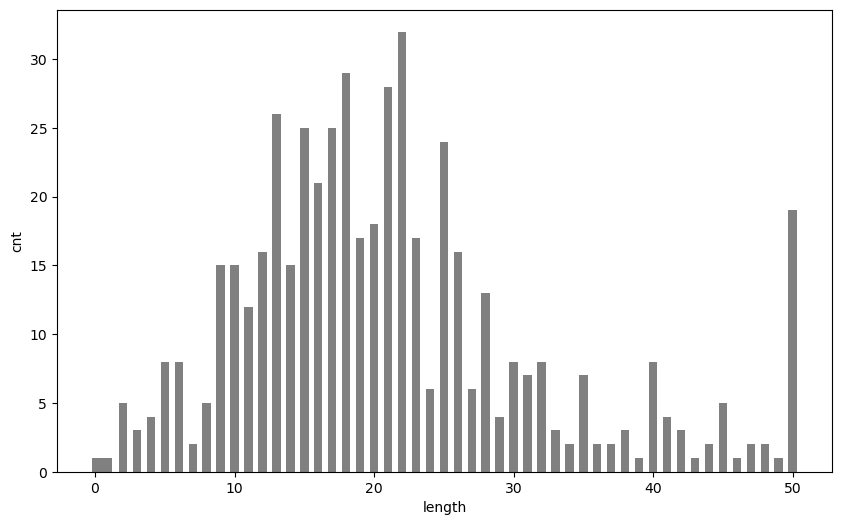

In [599]:
import matplotlib.pyplot as plt
xs=A_L.index.to_list()
ys=A_L['암의 장경'].to_list()
plt.figure(figsize=(10, 6))
plt.xlabel('length')
plt.ylabel('cnt')
plt.bar(xs, ys, width=0.6, color='grey')

In [600]:
A_L = train_df[train_df['N_category'] == 0]['암의 장경'].value_counts()
A_L = pd.DataFrame(A_L)
A_L = A_L.sort_index()

<BarContainer object of 45 artists>

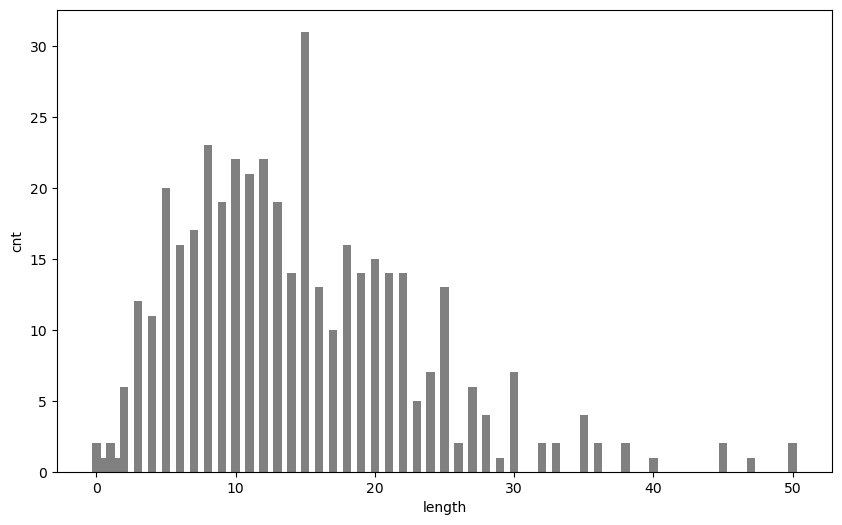

In [601]:
import matplotlib.pyplot as plt
xs=A_L.index.to_list()
ys=A_L['암의 장경'].to_list()
plt.figure(figsize=(10, 6))
plt.xlabel('length')
plt.ylabel('cnt')
plt.bar(xs, ys, width=0.6, color='grey')

##### 암의 장경이 클 수록 전이될 확률이 높다

In [602]:
train_df[train_df['N_category'] == 0]['암의 장경'].mean()

14.472090261282661

In [603]:
train_df[train_df['N_category'] == 1]['암의 장경'].mean()

21.150784313725488

In [604]:
A_C = train_df[train_df['N_category'] == 0]['암의 장경']

In [605]:
A_C = pd.DataFrame(A_C)
A_C = A_C.dropna(axis=0)

In [606]:
A_C.sort_values(by='암의 장경' ,ascending= True)[:315]

,암의 장경
3,0.00
5,0.00
927,0.35
888,0.40
756,0.60
...,...
745,19.00
680,19.00
773,19.00
41,19.00


##### 19 이상일 수록 림프절 전이 확률이 높다!@@@@@@@@@@

In [607]:
#크기 19이상
train_df['X_1'] = 0
train_df.loc[(train_df["암의 장경"]>=19) & (train_df["X_1"] == 0), "X_1"] = 1
train_df['X_1'].value_counts()

0    608
1    392
Name: X_1, dtype: int64

##### 따라서 19 이상일때 전이률이 높으므로 새로운 변수를 추가해줄 수 있음

##### ------------------------------완료

In [608]:
train_df['HER2_SISH'].value_counts()

0.0    753
1.0    215
2.0     32
Name: HER2_SISH, dtype: int64

In [609]:
train_df[train_df['HER2_SISH'] == 0]['N_category'].value_counts()

0    397
1    356
Name: N_category, dtype: int64

##### 장경 크고 ER 과 PR 클 때 전이률이 높을 것이다.
-> 변수로만들면 장경을 1~8로 정규화하고 ER 과 PR을 제곱해서 루트

In [610]:
train_df['X_2'] = train_df["암의 장경"].copy()

In [611]:
train_df['X_2'].value_counts()

15.00    56
22.00    46
18.00    45
13.00    45
21.00    42
12.00    38
25.00    37
10.00    37
17.00    35
16.00    34
9.00     34
20.00    33
11.00    33
19.00    31
14.00    29
5.00     28
8.00     28
6.00     24
23.00    22
50.00    21
7.00     19
26.00    18
28.00    17
30.00    15
3.00     15
4.00     15
24.00    13
27.00    12
2.00     11
35.00    11
32.00    10
40.00     9
31.00     7
45.00     7
29.00     5
33.00     5
38.00     5
36.00     4
41.00     4
42.00     3
47.00     3
37.00     2
48.00     2
0.00      2
0.90      2
44.00     2
34.00     2
1.00      2
0.60      1
0.10      1
0.40      1
0.35      1
0.70      1
1.50      1
49.00     1
39.00     1
43.00     1
46.00     1
0.20      1
Name: X_2, dtype: int64

In [612]:
train_df['X_2'] = train_df['X_2'].replace(0, np.NaN)

>> -  암의 장경이 NAN인 값 74 개

In [613]:
train_df[train_df["HER2_SISH"].isnull()]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category,X_1,X_2


In [230]:
CA_df1 = train_df.drop(['ID','img_path','mask_path','수술연월일','X_1','N_category','BRCA_mutation','암의 장경'],axis=1)
print(CA_df1.columns)
CA_df1 = StandardScaler().fit_transform(CA_df1)

Index(['나이', '진단명', '암의 위치', '암의 개수', 'NG', 'HG', 'HG_score_1', 'HG_score_2',
       'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category',
       'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent',
       'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'X_2'],
      dtype='object')


In [231]:
CA_df1 = pd.DataFrame(CA_df1)
CA_df1.columns = ['나이', '진단명', '암의 위치', '암의 개수', 'NG', 'HG', 'HG_score_1', 'HG_score_2',
       'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category',
       'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent',
       'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'X_2']

In [232]:
CA_df1

,나이,진단명,암의 위치,암의 개수,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,X_2
0,0.828692,-0.363105,0.785585,-0.391666,-0.102043,-1.258711,-0.899725,-0.220110,-0.599184,1.399320,...,0.468807,0.876184,0.747330,-0.018065,-0.320547,-0.573447,-0.269525,-0.541815,NaN,0.043816
1,-0.238179,-0.363105,-1.003902,-0.391666,1.343317,1.547294,0.630144,1.305539,2.200080,-0.785411,...,-2.133073,NaN,-1.338097,NaN,2.758965,-0.573447,-1.334530,-0.541815,NaN,0.294089
2,-1.482862,-0.363105,0.785585,-0.391666,-0.102043,NaN,NaN,NaN,NaN,0.306955,...,0.468807,-0.012643,0.747330,-0.750044,-0.586022,-0.573447,-0.269525,-0.541815,NaN,NaN
3,0.028539,-0.363105,0.785585,-0.391666,1.343317,1.547294,0.630144,1.305539,0.800448,0.306955,...,-2.133073,NaN,-1.338097,NaN,-0.904592,1.743842,1.860486,-0.541815,NaN,NaN
4,0.295257,-0.363105,0.785585,-0.391666,-0.102043,0.144291,0.630144,-0.220110,-0.599184,1.399320,...,0.468807,0.876184,-1.338097,NaN,-0.532927,1.743842,0.795480,3.342163,0.403844,-0.873853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.006504,-0.363105,0.785585,-0.391666,-1.547404,-1.258711,-0.899725,-1.745760,-0.599184,-0.785411,...,0.468807,NaN,-1.338097,NaN,NaN,-0.573447,-1.334530,-0.541815,NaN,0.544362
996,-0.504897,-0.363105,-1.003902,-0.391666,-1.547404,-1.258711,-2.429593,-1.745760,-0.599184,-0.785411,...,0.468807,NaN,0.747330,NaN,NaN,-0.573447,-1.334530,-0.541815,NaN,-0.957277
997,0.917598,-0.363105,0.785585,-0.391666,-1.547404,-1.258711,-0.899725,-1.745760,0.800448,-0.785411,...,0.468807,NaN,0.747330,NaN,NaN,-0.573447,-1.334530,-0.541815,NaN,-0.289882
998,-0.327085,-0.363105,-1.003902,-0.391666,-1.547404,-1.258711,-2.429593,-0.220110,-0.599184,-0.785411,...,-2.133073,NaN,-1.338097,NaN,NaN,-0.573447,-1.334530,-0.541815,NaN,-0.957277


<AxesSubplot:>

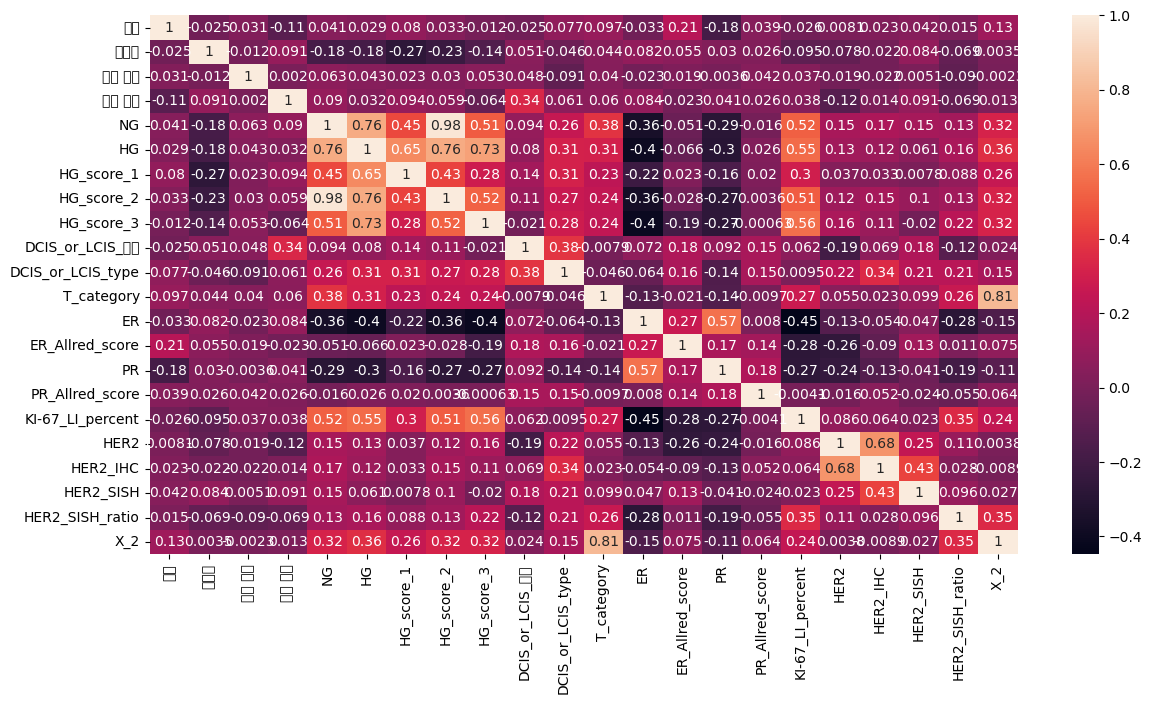

In [233]:
plt.figure(figsize = (14,7))
sns.heatmap(CA_df1.corr(), annot = True)

In [234]:
CA_df1['T_category'].isnull().sum()

4

In [235]:
train_df[train_df['T_category'].isnull()]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,X_1,X_2
109,BC_01_0547,./train_imgs/BC_01_0547.png,-,57,2019-04-22,1,2,1,0.0,2.0,...,NaN,28.27,1.0,3.0,0.0,NaN,NaN,1,0,NaN
115,BC_01_0561,./train_imgs/BC_01_0561.png,-,54,2019-03-14,1,2,1,0.0,NaN,...,NaN,42.81,0.0,1.0,0.0,NaN,NaN,1,0,NaN
117,BC_01_0567,./train_imgs/BC_01_0567.png,-,42,2019-02-01,1,2,1,0.0,3.0,...,7.0,47.79,0.0,0.0,0.0,NaN,NaN,1,0,NaN
878,BC_01_3019,./train_imgs/BC_01_3019.png,-,53,2007-08-27,1,1,1,27.0,NaN,...,NaN,NaN,1.0,3.0,0.0,NaN,NaN,1,1,27.0


In [343]:
train_df[train_df['T_category'].isnull()].iloc[:,[3,5,6,7,8,9,10,11,12,13,14,15,16,17]]

     나이  진단명  암의 위치  암의 개수  암의 장경   NG   HG  HG_score_1  HG_score_2  \
109  57    1      2      1    0.0  2.0  2.0         3.0         2.0   
115  54    1      2      1    0.0  NaN  NaN         NaN         NaN   
117  42    1      2      1    0.0  3.0  2.0         3.0         3.0   
878  53    1      1      1   27.0  NaN  NaN         NaN         NaN   

     HG_score_3  DCIS_or_LCIS_여부  DCIS_or_LCIS_type  T_category   ER  
109         2.0                1                NaN         NaN  0.0  
115         NaN                1                NaN         NaN  0.0  
117         1.0                1                NaN         NaN  1.0  
878         NaN                1                NaN         NaN  0.0  
     ER_Allred_score   PR  PR_Allred_score  KI-67_LI_percent  HER2  HER2_IHC  \
109              NaN  0.0              NaN             28.27   1.0       3.0   
115              NaN  0.0              NaN             42.81   0.0       1.0   
117              7.0  1.0              7.0       

In [237]:
train_df[train_df['T_category'].isnull()].iloc[:,[18,19,20,21,22,23,24,25,26,27,28]]

,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,X_1
109,NaN,0.0,NaN,0.0,NaN,28.27,1.0,3.0,0.0,NaN,NaN,1,0
115,NaN,0.0,NaN,0.0,NaN,42.81,0.0,1.0,0.0,NaN,NaN,1,0
117,NaN,1.0,7.0,1.0,7.0,47.79,0.0,0.0,0.0,NaN,NaN,1,0
878,NaN,0.0,NaN,1.0,NaN,NaN,1.0,3.0,0.0,NaN,NaN,1,1


In [614]:
train_df = train_df.drop(['암의 장경'],axis=1)

In [249]:
train_df.loc[(train_df["X_2"]>=19+19//4) & (train_df["T_category"].isnull())]

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,NG,HG,...,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,X_1,X_2
878,BC_01_3019,./train_imgs/BC_01_3019.png,-,53,2007-08-27,1,1,1,NaN,NaN,...,NaN,NaN,1.0,3.0,0.0,NaN,NaN,1,1,27.0


In [255]:
train_df[(train_df["T_category"] == 2)]["X_2"].mean()

27.715081967213116

In [248]:
train_df.loc[(train_df["X_2"]>=19+19//4) & (train_df["T_category"])]["T_category"].value_counts()

2.0    215
3.0     16
4.0      4
1.0      1
Name: T_category, dtype: int64

In [255]:
train_df[(train_df["T_category"] == 2)]["X_2"].mean()

27.715081967213116

In [620]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             0
ER                     0
ER_Allred_score      297
PR                     0
PR_Allred_score      453
KI-67_LI_percent     235
HER2                   4
HER2_IHC              24
HER2_SISH              0
HER2_SISH_ratio      825
N_category             0
X_1                    0
X_2                   71
dtype: int64

>> -  암의 장경은 X_2로 보면 되고 T카테고리하고 her2_sish 비율과 HG쪽에서 관련이 높다

In [ ]:
##### scaler = StandardScaler()
data_scaler = scaler.fit_transform(data_filled_tr)
data_scaler = pd.DataFrame(data_scaler)
data_scaler.columns = ['나이', '진단명', '암의 위치', '암의 개수', 'NG', 'HG', 'HG_score_1', 'HG_score_2',
       'HG_score_3', 'T_category', 'HER2_SISH_ratio', '암의 장경', 'N_category']

data_scaler = data_scaler.drop(['암의 장경'],axis=1)
data_scaler = pd.concat([data_scaler,data_len], axis = 1)
df_train, df_test = datawig.utils.random_split(data_scaler)
imputer = datawig.SimpleImputer(
    input_columns=['나이','진단명','암의 위치','암의 개수','NG','HG',
                       'HG_score_1','HG_score_2','HG_score_3','T_category','HER2_SISH_ratio','N_category'],
    output_column='암의 장경'
    )
imputer.fit(train_df = df_train)
imputed = imputer.predict(df_test)

In [47]:
train_df.columns

Index(['ID', 'img_path', 'mask_path', '나이', '수술연월일', '진단명', '암의 위치', '암의 개수',
       '암의 장경', 'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type', 'T_category', 'ER',
       'ER_Allred_score', 'PR', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2',
       'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio', 'BRCA_mutation',
       'N_category'],
      dtype='object')

In [625]:
from datawig import SimpleImputer
from sklearn.metrics import f1_score, classification_report
from datawig.utils import random_split

df_train, df_test = random_split(train_df, split_ratios=[0.8, 0.2])

In [634]:
#Initialize a SimpleImputer model
imputer = SimpleImputer(
    input_columns=['나이','진단명','암의 위치','암의 개수','HER2_SISH','HER2','T_category'
                  ,'ER','PR','ER_Allred_score','DCIS_or_LCIS_여부','X_1'],
    output_column='X_2'
)

#Fit an imputer model on the train data
imputer.fit(train_df=train_df)

# Initialize a SimpleImputer model
imputer = SimpleImputer(
    input_columns=['나이','진단명','암의 위치','암의 개수','HER2_SISH','HER2','T_category'
                  ,'ER','PR','ER_Allred_score','DCIS_or_LCIS_여부'],
    output_column='암의 장경'
)

# Fit an imputer model on the train data
imputer.fit(train_df=df_train, num_epochs=5)

# Impute missing values and return original dataframe with predictions
predictions = imputer.predict(df_test)
predictions = predictions[['암의 장경', '암의 장경_imputed']]
predictions = predictions.dropna(subset=['암의 장경'])

imputer.fit_hpo(
    train_df=df_train,
    num_epochs=100,
    learning_rate_candidates=[1e-2, 1e-3, 1e-4, 1e-5],
    final_fc_hidden_units=[[100], [200]]
)

In [635]:
predictions = imputer.predict(train_df)

>>- 옆 칼럼 값으로 결측치 변경

In [644]:
predictions['X_2'] = predictions['X_2'].replace(np.nan, predictions['X_2_imputed'])

In [651]:
predictions['X_2'] = predictions['X_2'].astype(int)

In [649]:
predictions = predictions.drop(['X_2_imputed'],axis =1)

In [652]:
predictions

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,NG,HG,...,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,N_category,X_1,X_2
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,2.0,1.0,...,1.0,6.0,12.0,0.0,1.0,0.0,NaN,0,1,19
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,3.0,3.0,...,0.0,NaN,70.0,0.0,0.0,0.0,NaN,1,1,22
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,2.0,NaN,...,1.0,4.0,7.0,0.0,1.0,0.0,NaN,0,0,19
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,3.0,3.0,...,0.0,NaN,1.0,1.0,3.0,0.0,NaN,0,0,14
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,2.0,2.0,...,0.0,NaN,8.0,1.0,2.0,2.0,5.44,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,./train_imgs/BC_01_3464.png,-,65,2006-12-22,1,2,1,1.0,1.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,1,1,25
996,BC_01_3482,./train_imgs/BC_01_3482.png,-,48,2006-11-17,1,1,1,1.0,1.0,...,1.0,NaN,NaN,0.0,0.0,0.0,NaN,0,0,7
997,BC_01_3485,./train_imgs/BC_01_3485.png,-,64,2006-11-10,1,2,1,1.0,1.0,...,1.0,NaN,NaN,0.0,0.0,0.0,NaN,1,0,15
998,BC_01_3502,./train_imgs/BC_01_3502.png,-,50,2006-09-22,1,1,1,1.0,1.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0,0,7


In [ ]:
#Calculate f1 score
f1 = f1_score(predictions['finish'], predictions['finish_imputed'])

#Print overall classification report
print(classification_report(predictions['finish'], predictions['finish_imputed']))

In [36]:
df_train = df_train.dropna(subset=['암의 장경'])

In [ ]:
data_filled_tr[['암의 장경']]

In [41]:
imputer.fit_hpo(
    train_df=df_train,
    num_epochs=50,
    learning_rate_candidates=[1e-2, 1e-3, 1e-4, 1e-5],
    final_fc_hidden_units=[[100], [200]]
)

In [43]:
df_train

,나이,진단명,암의 위치,암의 개수,NG,HG,HG_score_1,HG_score_2,HG_score_3,T_category,HER2_SISH_ratio,N_category,암의 장경
841,-0.415991,-0.363105,-1.003902,-0.391666,1.343317,0.144291,0.630144,1.305539,-0.599184,1.139809,NaN,-1.028403,30.0
956,-0.860521,-0.363105,0.785585,-0.391666,1.343317,1.547294,0.630144,1.305539,2.200080,-0.441319,NaN,0.972381,14.0
544,1.717752,3.406147,0.785585,-0.391666,-1.547404,-1.258711,-2.429593,-1.745760,-0.599184,-0.441319,NaN,-1.028403,7.0
759,-0.593803,-0.363105,0.785585,-0.391666,-0.102043,0.144291,0.630144,-0.220110,0.800448,-0.441319,NaN,-1.028403,18.0
955,-1.127238,-0.363105,-1.003902,-0.391666,-0.102043,-1.258711,-2.429593,-0.220110,-0.599184,-0.441319,NaN,0.972381,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,-0.504897,-0.363105,-1.003902,-0.391666,-1.547404,-1.258711,-0.899725,-1.745760,-0.599184,-0.441319,NaN,-1.028403,10.0
213,1.095410,-0.363105,0.785585,2.553193,1.343317,1.547294,0.630144,1.305539,2.200080,1.139809,NaN,0.972381,28.0
465,-0.682709,0.893313,2.575072,-0.391666,-0.102043,0.144291,0.630144,-0.220110,-0.599184,-0.441319,-0.191172,-1.028403,13.0
206,-1.127238,-0.363105,-1.003902,-0.391666,-0.102043,0.144291,-0.899725,-0.220110,0.800448,-0.441319,-0.178973,0.972381,14.0


In [42]:
imputer.fit_hpo(train_df = df_train)
imputed = imputer.predict(df_test)
imputed_all = imputer.predict(data_scaler)

imputed_all = pd.DataFrame(imputed_all)

In [40]:
imputed_all

,나이,진단명,암의 위치,암의 개수,NG,HG,HG_score_1,HG_score_2,HG_score_3,T_category,HER2_SISH_ratio,N_category,암의 장경,암의 장경_imputed
0,0.828692,-0.363105,0.785585,-0.391666,-0.102043,-1.258711,-0.899725,-0.220110,-0.599184,-0.441319,NaN,-1.028403,19.0,10.472107
1,-0.238179,-0.363105,-1.003902,-0.391666,1.343317,1.547294,0.630144,1.305539,2.200080,1.139809,NaN,0.972381,22.0,33.882522
2,-1.482862,-0.363105,0.785585,-0.391666,-0.102043,NaN,NaN,NaN,NaN,-2.022446,NaN,-1.028403,NaN,5.757641
3,0.028539,-0.363105,0.785585,-0.391666,1.343317,1.547294,0.630144,1.305539,0.800448,-2.022446,NaN,-1.028403,0.0,11.611329
4,0.295257,-0.363105,0.785585,-0.391666,-0.102043,0.144291,0.630144,-0.220110,-0.599184,-0.441319,0.403844,-1.028403,8.0,10.590622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.006504,-0.363105,0.785585,-0.391666,-1.547404,-1.258711,-0.899725,-1.745760,-0.599184,1.139809,NaN,0.972381,25.0,25.738144
996,-0.504897,-0.363105,-1.003902,-0.391666,-1.547404,-1.258711,-2.429593,-1.745760,-0.599184,-0.441319,NaN,-1.028403,7.0,7.196884
997,0.917598,-0.363105,0.785585,-0.391666,-1.547404,-1.258711,-0.899725,-1.745760,0.800448,-0.441319,NaN,0.972381,15.0,16.647095
998,-0.327085,-0.363105,-1.003902,-0.391666,-1.547404,-1.258711,-2.429593,-0.220110,-0.599184,-0.441319,NaN,-1.028403,7.0,9.748686


In [ ]:
imputed_all

In [ ]:
imputed_all = imputed_all.astype(int)

In [38]:
data_filled_tr[['암의 장경']]= data_filled_tr[['암의 장경']].fillna(imputed_all)

NameError: name 'imputed_all' is not defined

In [ ]:
imputed_all.columns = ['암의 장경']

In [ ]:
data_filled_tr = data_filled_tr.drop(['암의 장경'],axis=1)

In [ ]:
data_filled_tr = pd.concat([imputed_all,data_filled_tr],axis =1 )

In [ ]:
data_filled_tr

In [ ]:
data_filled_tr.isnull().sum()

In [ ]:
imputed_all = np.where(pd.notnull(imputed_all['암의 장경']) == True, imputed_all['암의 장경'], imputed_all['암의 장경_imputed'])

In [ ]:
imputer.fit_hpo(train_df = df_train)
imputed = imputer.predict(df_test)
imputed_all = imputer.predict(data_scaler)

imputed_all = pd.DataFrame(imputed_all)

In [ ]:
imputer.fit_hpo(
    train_df=df_train,
    num_epochs=50,
    learning_rate_candidates=[1e-2, 1e-3, 1e-4, 1e-5],
    final_fc_hidden_units=[[100], [200]]
)

In [ ]:
scaler = StandardScaler()
data_scaler = scaler.fit_transform(data_filled_tr)
data_scaler = pd.DataFrame(data_scaler)
data_scaler.columns = ['나이', '진단명', '암의 위치', '암의 개수', 'NG', 'HG', 'HG_score_1', 'HG_score_2',
       'HG_score_3', 'T_category', 'HER2_SISH_ratio', '암의 장경', 'N_category']

data_scaler = data_scaler.drop(['암의 장경'],axis=1)
data_scaler = pd.concat([data_scaler,data_len], axis = 1)
df_train, df_test = datawig.utils.random_split(data_scaler)
imputer = datawig.SimpleImputer(
    input_columns=['나이','진단명','암의 위치','암의 개수','NG','HG',
                       'HG_score_1','HG_score_2','HG_score_3','T_category','HER2_SISH_ratio','N_category'],
    output_column='암의 장경'
    )
imputer.fit(train_df = df_train)
imputed = imputer.predict(df_test)

In [ ]:
imputed = imputed.dropna(subset=['암의 장경'])

In [ ]:
imputed

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
plt.figure(figsize = (14,7))
sns.heatmap(imputed.corr(), annot = True)

In [ ]:
f1 = f1_score(imputed['암의 장경'], imputed['암의 장경_imputed'])

#Print overall classification report
print(classification_report(imputed['암의 장경'], imputed['암의 장경_imputed']))

In [ ]:
predictions = imputer.predict(data_filled_tr)

In [ ]:
predictions

In [40]:
imputer.fit_hpo(train_df=df_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
df_train, df_test = datawig.utils.random_split(data_filled_tr)

In [ ]:
predictions['암의 장경_imputed'] = predictions['암의 장경_imputed'].round(0).astype(int)

f1 = f1_score(predictions['암의 장경'], predictions['암의 장경_imputed'])

#Print overall classification report
print(classification_report(predictions['암의 장경'], predictions['암의 장경_imputed']))

imputer_numeric.fit_hpo(
    train_df=df_train,
    num_epochs=50,
    learning_rate_candidates=[1e-3, 1e-4],
    latent_dim_candidates=[50, 100],
    hidden_layers_candidates=[0, 2],
    final_fc_hidden_units=[[100]]
)

imputer.predict(data_filled_tr)

null = imputer.predict(data_filled_tr)

In [ ]:
train_df.loc[(train_df["암의 장경"]<=32) &(train_df["암의 장경"]>=19) & (train_df["T_category"].isnull()), "T_category"] = 2

In [653]:
test_df = test_df.fillna(0)
train_df = predictions.fillna(0)

In [655]:
CFG = {
    'IMG_SIZE':920,
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4,
    'SEED':41
}

In [656]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [657]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )

In [658]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

KeyError: 'X_1'